**Download Data**

Mount my google drive, where the dataset is stored.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Unzip the dataset into the folder "dataset".

In [0]:
!rm -vrf "dataset"
!mkdir "dataset"
!cp -r "/content/drive/My Drive/cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
!unzip "dataset/cervigram-image-dataset-v2.zip" -d "dataset"

**Constants**

In [0]:
TRAIN_PATH = '/content/dataset/data/train/'
TEST_PATH = '/content/dataset/data/test/'

CROP_SIZE = 260
IMAGE_SIZE = 224
BATCH_SIZE = 100

**Imports**

In [0]:
import torch as t
import torchvision as tv
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import Linear, BCEWithLogitsLoss
import sklearn as sk
import sklearn.metrics
from os import listdir
import time
import random

**Deterministic Measurements**

This statements help making the experiments reproductible by fixing the random seeds.

In [0]:
SEED = 0
t.manual_seed(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

**Loading Data**

The dataset is structured in multiple small folders, ecah containing 7 images. The generator iterates through the folders and returns the category and 7 paths: one for each image in the folder.

In [0]:
def sortByLastDigits(elem):
  chars = [c for c in elem if c.isdigit()]
  return 0 if len(chars) == 0 else int(''.join(chars))

def getImagesPaths(root_path):
  for  class_folder in [root_path + f for f in listdir(root_path)]:
      category = int(class_folder[-1])
      for case_folder in listdir(class_folder):
        case_folder_path = class_folder + '/' + case_folder + '/'
        img_files = [case_folder_path + file_name for file_name in listdir(case_folder_path)]
        yield category, sorted(img_files, key = sortByLastDigits)

We define 3 datasets, which loads 3 kinds of images: natural images, images taken through a green lens and images where the doctor aplied iodine solution (which gives a dark red colour). Each dataset has dynamic and static transformations which could be applied to the data. The static transformations are applied on the initialization of the dataset, while the dynamic ones are applied when loading each batch of data.

In [0]:
class SimpleImagesDataset(t.utils.data.Dataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
      for i in range(5):
        img = pil.Image.open(img_files[i])
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.transforms_x != None:
      x = self.transforms_x(x)
    if self.transforms_y != None:
      y = self.transforms_y(y)
    return x, y

  def __len__(self):
    return len(self.dataset)

class GreenLensImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-2]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

class RedImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-1]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

**Preprocess Data**

Convert pytorch tensor to numpy array.

In [0]:
def to_numpy(x):
  return x.cpu().detach().numpy()

Data transformations for the test and training sets.

In [0]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

transforms_train = tv.transforms.Compose([
    tv.transforms.RandomAffine(degrees  = 45, translate = None, scale = (1., 2.), shear = 30),
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda t: t.cuda()),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

transforms_test = tv.transforms.Compose([
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

y_transform = tv.transforms.Lambda(lambda y: t.tensor(y, dtype=t.long, device = 'cuda:0'))

Initialize pytorch datasets and loaders for training and test.

In [0]:
def create_loaders(dataset_class):
  dataset_train = dataset_class(TRAIN_PATH, transforms_x_dynamic = transforms_train, transforms_y_dynamic = y_transform)
  dataset_test = dataset_class(TEST_PATH, transforms_x_static = transforms_test, 
                                                transforms_x_dynamic = tv.transforms.Lambda(lambda t: t.cuda()), transforms_y_dynamic = y_transform)

  loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True)
  loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = False)
  return loader_train, loader_test, len(dataset_train), len(dataset_test)

In [0]:
loader_train_simple_img, loader_test_simple_img, len_train, len_test = create_loaders(GreenLensImagesDataset)

**Visualize Data**

Load a few images so that we can see the efects of the data augmentation on the training set.

In [0]:
def plot_one_prediction(x, label, pred):  
  x, label, pred = to_numpy(x), to_numpy(label), to_numpy(pred)
  x = np.transpose(x, [1, 2, 0])
  if x.shape[-1] == 1:
    x = x.squeeze()
  x = x * np.array(norm_std) + np.array(norm_mean)
  plt.title(label, color = 'green' if label == pred else 'red')
  plt.imshow(x)

def plot_predictions(imgs, labels, preds):  
  fig = plt.figure(figsize = (20, 5))
  for i in range(20):
    fig.add_subplot(2, 10, i + 1, xticks = [], yticks = [])
    plot_one_prediction(imgs[i], labels[i], preds[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

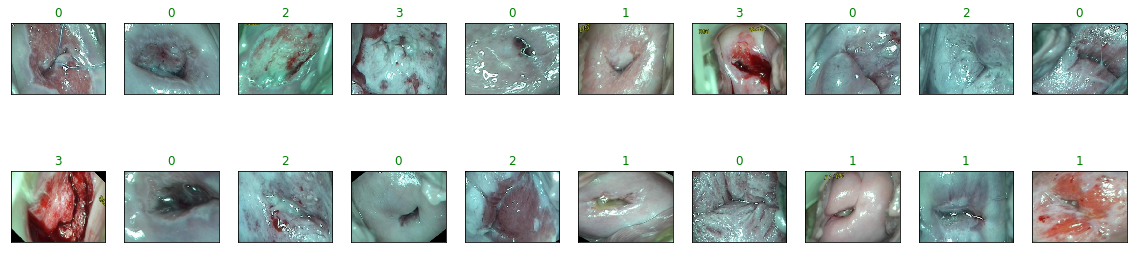

In [126]:
x, y = next(iter(loader_train_simple_img))
plot_predictions(x, y, y)

**Model**

Define a few models to experiment with.

In [0]:
def get_mobilenet_v2():
  model = t.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
  model.classifier[0] = t.nn.Dropout(p=0.9, inplace=False)
  model.classifier[1] = Linear(in_features=1280, out_features=4, bias=True)
  model.features[18].add_module('cnn_drop_18', t.nn.Dropout2d(p = .3))
  model.features[17]._modules['conv'][1].add_module('cnn_drop_17', t.nn.Dropout2d(p = .2))
  model.features[16]._modules['conv'][1].add_module('cnn_drop_16', t.nn.Dropout2d(p = .1))
  model = model.cuda()
  return model

def get_vgg_19():
  model = tv.models.vgg19(pretrained = True)
  model = model.cuda()
  model.classifier[2].p = .9
  model.classifier[6].out_features = 4
  return model

def get_res_next_101():
  model = t.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
  model.fc = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features=2048, out_features=4)
  )
  model = model.cuda()
  return model

def get_resnet_18():
  model = tv.models.resnet18(pretrained = True)
  model.fc = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features=512, out_features=4)
  )
  model = model.cuda()
  return model

def get_dense_net():
  model = tv.models.densenet121(pretrained = True)
  model.classifier = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features = 1024, out_features = 4)
  )
  model = model.cuda()
  return model

Based on multiple experiments, I recommend the resnet 18 network as being most convenient (taking into account accuracy and size of the model).

In [128]:
model_simple = get_mobilenet_v2()

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


**Train & Evaluate**

Timer utility function. This is used to measure the execution speend.

In [0]:
time_start = 0

def timer_start():
  global time_start
  time_start = time.time()

def timer_end():
  return time.time() - time_start

This function trains the network and e valuates it at the same time. It outputs the metrics recorder during the training for both train and test. We are measuring accuracy and the loss. The function also saves a checkpoint of the model every time the accuracy is imporved. In the end we will have a checkpoint of the model which gave the best accuracy.

In [0]:
def train_eval(optimizer, model, loader_train, loader_test, chekpoint_name, epochs):
  metrics = {
      'losses_train': [],
      'losses_test': [],
      'acc_train': [],
      'acc_test': []
  }

  best_acc = 0
  
  loss_fn = t.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    timer_start()
    train_epoch_acc, train_epoch_loss = 0, 0
    test_epoch_acc, test_epoch_loss = 0, 0

    # Train
    model.train()
    for x, y in loader_train:
      y_pred = model.forward(x)
      loss = loss_fn(y_pred, y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      pred = y_pred.argmax(axis = 1)
      ratio = len(y) / len_train
      train_epoch_loss += (loss * ratio)
      train_epoch_acc += (sk.metrics.classification.accuracy_score(y, pred) * ratio)
    metrics['losses_train'].append(train_epoch_loss)
    metrics['acc_train'].append(train_epoch_acc)
  
    # Evaluate
    model.eval()
    with t.no_grad():
      for x, y in loader_test:
        y_pred = model.forward(x)
        loss = loss_fn(y_pred, y)
        y_pred, y = to_numpy(y_pred), to_numpy(y)
        pred = y_pred.argmax(axis = 1)
        ratio = len(y) / len_test
        test_epoch_loss += (loss * ratio)
        test_epoch_acc += (sk.metrics.classification.accuracy_score(y, pred) * ratio )
      metrics['losses_test'].append(test_epoch_loss)
      metrics['acc_test'].append(test_epoch_acc)
  
    if metrics['acc_test'][-1] > best_acc:
      best_acc = metrics['acc_test'][-1]
      t.save({'model': model.state_dict()}, 'checkpint {}.tar'.format(chekpoint_name))
    print('Epoch {} acc {} minutes {}'.format(epoch + 1, metrics['acc_test'][-1], timer_end() / 60))
  print('Ended training')
  
  return metrics

Plot a metric for both train and test.

In [0]:
def plot_train_test(train, test, title):
    plt.plot(range(len(train)), train, label = 'train')
    plt.plot(range(len(test)), test, label = 'test')
    plt.title(title)
    plt.legend()
    plt.show()

Train a model for several epochs. The steps_learning parameter is a list of tuples. Each tuple specifies the steps and the learning rate.

In [0]:
def do_train(model, loader_train, loader_test, checkpoint_name, steps_learning):
  for steps, learn_rate in steps_learning:
    metrics = train_eval(t.optim.Adam(model.parameters(), lr = learn_rate, weight_decay = 0), model, loader_train, loader_test, checkpoint_name, steps)
    print('Best test accuracy :', max(metrics['acc_test']))
    plot_train_test(metrics['losses_train'], metrics['losses_test'], 'Loss (lr = {})'.format(learn_rate))
    plot_train_test(metrics['acc_train'], metrics['acc_test'], 'Accuracy (lr = {})'.format(learn_rate))

Perform actual training

Epoch 1 acc 0.25 minutes 0.14173643986384074
Epoch 2 acc 0.25 minutes 0.11997992992401123
Epoch 3 acc 0.3333333333333333 minutes 0.11892361243565877
Epoch 4 acc 0.3125 minutes 0.11977641185124716
Epoch 5 acc 0.3541666666666667 minutes 0.12096238136291504
Epoch 6 acc 0.4166666666666667 minutes 0.12031489610671997
Epoch 7 acc 0.3541666666666667 minutes 0.12019308010737101
Epoch 8 acc 0.375 minutes 0.12020757993062338
Epoch 9 acc 0.3333333333333333 minutes 0.12085622549057007
Epoch 10 acc 0.3125 minutes 0.12065478960673014
Epoch 11 acc 0.375 minutes 0.12015860478083293
Epoch 12 acc 0.375 minutes 0.1204025665918986
Epoch 13 acc 0.375 minutes 0.12002527713775635
Epoch 14 acc 0.3541666666666667 minutes 0.11988322734832764
Epoch 15 acc 0.3541666666666667 minutes 0.12025314966837565
Epoch 16 acc 0.375 minutes 0.12014470100402833
Epoch 17 acc 0.375 minutes 0.11987082163492839
Epoch 18 acc 0.375 minutes 0.1200624426205953
Epoch 19 acc 0.3958333333333333 minutes 0.11990652481714885
Epoch 20 acc 0

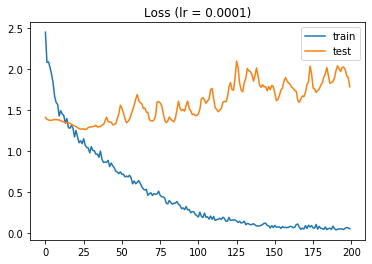

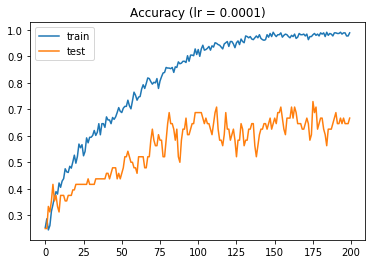

In [133]:
do_train(model_simple, loader_train_simple_img, loader_test_simple_img, 'simple_1', [(200, 1e-4)])

In [0]:
def correct_accuracy_score(incorrect_acc):
  return ( len(loader_test_simple_img) * incorrect_acc ) / len_test